In [3]:
!pip install diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 39.6 MB/s eta 0:00:0000:0100:01m
  Using cached ftfy-6.1.1-py3-none-any.whl (53 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 36.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.2 MB/s eta 0:00:00
  Using cached regex-2023.10.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (773 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 54.1 MB/s eta 0:00:00
  Using cached pandas-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Using cached aiohttp-3.8.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 65.4 MB

https://huggingface.co/settings/tokens

In [4]:
from huggingface_hub import notebook_login

notebook_login()

# Utils

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im
    


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data

In [2]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("leffff/south-park-character-png-dataset", split="train")


IMAGE_SIZE = 32
BATCH_SIZE = 64

preprocess = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True
)

/home/leffff/PycharmProjects/south-park-character-generation/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Resolving data files: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 951/951 [00:09<00:00, 101.00it/s]












Extracting data files: 0it [00:00, ?it/s]
Generating train split: 951 examples [00:00, 19067.02 examples/s]


X shape: torch.Size([8, 3, 32, 32])


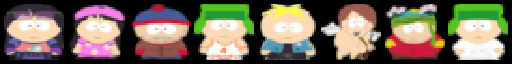

In [3]:
x_batch = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", x_batch.shape)
show_images(x_batch).resize((8 * 64, 64), resample=Image.NEAREST)

In [4]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

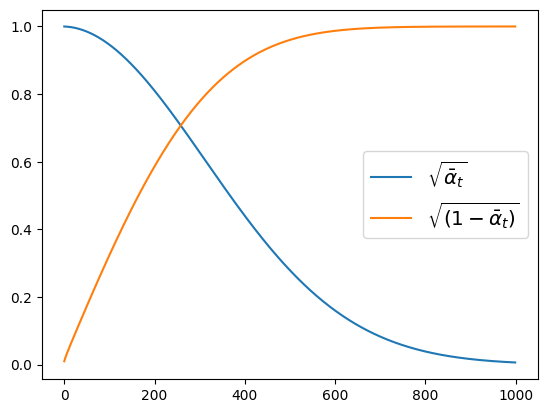

In [5]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

Noisy X shape torch.Size([8, 3, 32, 32])


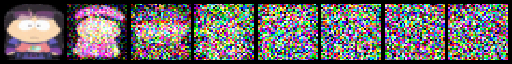

In [6]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(x_batch)
noisy_x_batch = noise_scheduler.add_noise(x_batch, noise, timesteps)
print("Noisy X shape", noisy_x_batch.shape)
show_images(noisy_x_batch).resize((8 * 64, 64), resample=Image.NEAREST)

# Model

In [28]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=IMAGE_SIZE,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

# Let's Trains

In [36]:
from tqdm.auto import tqdm 

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="linear"
)

# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

losses = []

for epoch in range(100):
    for batch in tqdm(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.88it/s]


Epoch:5, loss: 0.042924363041917483


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.73it/s]


Epoch:10, loss: 0.047500843678911525


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.08it/s]


Epoch:15, loss: 0.04025653998057047


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.10it/s]


Epoch:20, loss: 0.03559409379959107


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.86it/s]


Epoch:25, loss: 0.04780189841985703


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.89it/s]


Epoch:30, loss: 0.036690128842989604


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.94it/s]


Epoch:35, loss: 0.03992449666062991


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.96it/s]


Epoch:40, loss: 0.03916581571102142


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.81it/s]


Epoch:45, loss: 0.031096759190162023


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.76it/s]


Epoch:50, loss: 0.03893779640396436


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.72it/s]


Epoch:55, loss: 0.03655186221003533


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.73it/s]


Epoch:60, loss: 0.03246508079270522


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.51it/s]


Epoch:65, loss: 0.035346729184190434


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.62it/s]


Epoch:70, loss: 0.036513590688506764


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.64it/s]


Epoch:75, loss: 0.033995865782101946


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.68it/s]


Epoch:80, loss: 0.03551308090488116


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.65it/s]


Epoch:85, loss: 0.03617755807936192


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.33it/s]


Epoch:90, loss: 0.03481887492040793


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.77it/s]


Epoch:95, loss: 0.032305516054232916


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.85it/s]

Epoch:100, loss: 0.03267561942338944


# Let's sample

In [37]:
from diffusers import DDPMPipeline
image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.17it/s]


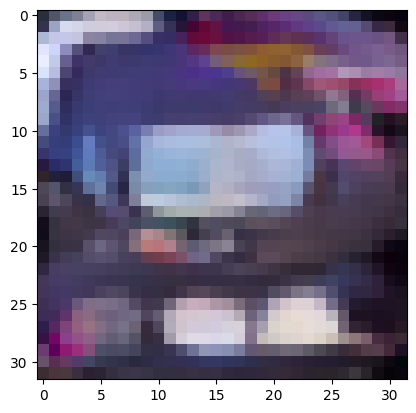

In [43]:
pipeline_output = image_pipe()
plt.imshow(pipeline_output.images[0])